In [10]:
# Imports, as always...
from os import listdir, makedirs, path
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import pickle
import torch
from datetime import datetime
from math import log

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

from torch.nn import Sequential, Linear, ReLU, Softmax
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn.functional import one_hot

from sklearn.svm import SVC

# Graphical imports.
import matplotlib.pyplot as plt
import seaborn as sns

# Styling.
palette = 'deep'
sns.set_theme(style='darkgrid', palette=palette)

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Random seeds.
torch.manual_seed(42)
np.random.seed(42)

# Fingerprint Classification

This notebook aims to replicate and advance the approaches to classification in [Martina et al. (2021)](https://arxiv.org/pdf/2109.11405), in which an SVM is used to binarily classify whether a given classical measurement was or was not produced by a given quantum circuit.

This is a simple task which, when taken together with their *very* small circuit, yields for near perfect accuracy. Here, we will complicate things to push the capability of the models to investigate more thoroughly what may or may not be possible with regard to classifying the membership of a quantum state to a quantum device by its "noise fingerprint". 

The ideas fitting into the work of this notebook are as follows:
- *Multi-class classification*. Using the data produced by Martina et al. (2021), can we present a multi-class prediction model that is not given any bias towards any particular model -- given a measurement of a quantum state, which device produced it?
- *Larger/deeper circuits*. How does the performance degrade as the number of qubits increases, or as the circuit depth increases?
- *Noise severity analysis*. Under which severities/forms of noise is performance best? Ideally, we can produce a visualisation of performance (e.g. accuracy) vs. noise intensity/severity. We might expect poor performance with little/no noise (not enough distinguishing information between membership classes), good performance with moderate noise, then poor performance again with large amounts of noise (too much randomness).

For clarity, 'membership to a quantum device' in this context refers to 'being produced by that device'.

## Martina et al. (2021)'s Dataset

Only the raw data is given, and the `createDataset.py` and `extractExecuction.py` scripts are abhorrent messes and crimes against humanity, so I'll do my best to re-create the "extracting" and "creating" process for a dataset from the data on their [GitHub](https://github.com/trianam/learningQuantumNoiseFingerprint/tree/main).

In [3]:
# List all files in the "walker" directory.
file_list = listdir('./martina/data/walker')

# List of machines.
# Note: IBM Bogota's files cannot be read -- ALL lead to pickle underflow.
machines = ['ibmq_athens', 'ibmq_casablanca', 'ibmq_lima', 'ibmq_quito', 'ibmq_santiago', 'ibmq_5_yorktown']

# How many files does each machine have.
counts = {machine : 0 for machine in machines}
for file in file_list:
    for machine in machines:
        if machine in file:
            counts[machine] += 1

# Any count above 250 includes custom splits -- we're not too interested in those.
display(counts)

{'ibmq_athens': 750,
 'ibmq_casablanca': 500,
 'ibmq_lima': 250,
 'ibmq_quito': 250,
 'ibmq_santiago': 250,
 'ibmq_5_yorktown': 250}

### Extracting

This is the process of reading the stored data and translating it into probability distributions.

In [4]:
# File paths.
base_path = './martina/data/walker'
extracted_path = './martina/data/walkerExtracted'
    
# Generate the output path.
makedirs(extracted_path, exist_ok=True)

# "Window sizes".
ks = [1000]

In [95]:
# Helper function to filter the file list into the (non-split) files of only a given machine.
def filter_to_machine(file_list, machine):
    # List of words that specify different types of data (e.g. split).
    no_words = ['split', 'bis']
    
    return filter(
        lambda file : machine in file and not (any([word in file for word in no_words])), file_list
    )

In [96]:
# Extracting executions for each machine.
for machine in tqdm(machines, desc='Extracting'):
    executions = []
    
    # For each file belonging to the current machine.
    for file in tqdm(filter_to_machine(file_list, machine), desc='Reading files', total=250):
        # Read the contents of the file.
        contents = pickle.load(open(path.join(base_path, file), 'rb'))
        
        # For each run of the circuit (of which there are 8000 in the Martina paper and data).
        for n in range(len(contents['results'][0]['data']['memory'])):
            current_execution = []
            
            # Note: we will not be doing repeated measures, nor will we "read all bits".
            
            # For each measurement step t (of which there are 9 in the Martina paper and data).
            for t in range(len(contents['results'])):
                execution = int(contents['results'][t]['data']['memory'][n], 0)
                current_execution.append(execution)

            executions.append(current_execution)
            
    # Cast to numpy array.
    executions = np.array(executions)
    
    # Save the full executions of this machine. 
    np.savetxt(path.join(extracted_path, f'{machine}-executions.csv'), executions)
    
    # Break the executions into windows to be saved.
    for k in ks:
        # The window size must cleanly divide the number of executions.
        if executions.shape[0] % k != 0: raise(Exception('Indivisible by window size.'))
        
        # Initialise probabilities array.
        probs = np.zeros(shape=(
            executions.shape[0] // k, executions.shape[1], np.unique(executions).shape[0]
        ), dtype=np.float32)
        
        # Calculate probabilities with the given window size.
        for n in tqdm(range(executions.shape[0]), desc='Calculating probabilities'):
            i = n // k
            
            for t in range(executions.shape[1]):
                probs[i, t, executions[n, t]] += 1
                
        probs = probs / k
        
        # Save the window.
        np.save(path.join(extracted_path, f'{machine}-probabilities-{k}.npy'), probs)

Extracting:   0%|          | 0/6 [00:00<?, ?it/s]

Reading files:   0%|          | 0/250 [00:00<?, ?it/s]

Calculating probabilities:   0%|          | 0/2000000 [00:00<?, ?it/s]

Reading files:   0%|          | 0/250 [00:00<?, ?it/s]

Calculating probabilities:   0%|          | 0/2000000 [00:00<?, ?it/s]

Reading files:   0%|          | 0/250 [00:00<?, ?it/s]

Calculating probabilities:   0%|          | 0/2000000 [00:00<?, ?it/s]

Reading files:   0%|          | 0/250 [00:00<?, ?it/s]

Calculating probabilities:   0%|          | 0/2000000 [00:00<?, ?it/s]

Reading files:   0%|          | 0/250 [00:00<?, ?it/s]

Calculating probabilities:   0%|          | 0/2000000 [00:00<?, ?it/s]

Reading files:   0%|          | 0/250 [00:00<?, ?it/s]

Calculating probabilities:   0%|          | 0/2000000 [00:00<?, ?it/s]

### Creating

Now we arrange the extracted run statistics into a dataset. For the sake of ease of use, we'll chuck all that into a PyTorch Dataset and then Dataloader.

In [5]:
# File paths.
dataset_path = './martina/data/walkerDataset'
makedirs(dataset_path, exist_ok=True)

# Specify the window size.
k = ks[0]

In [6]:
# Pack all the probability distributions (from all machines) into an array.
probs = [np.load(path.join(extracted_path, f'{machine}-probabilities-{k}.npy')) for machine in machines]
order = [np.arange(prob.shape[0]) for prob in probs]

# Features (x), labels (y) format.
xs, ys = [], []
for i in range(min(map(len, order))):
    for p in range(len(probs)):
        xs.append(probs[p][order[p][i]])
        ys.append(p)
        
# Numpify those arrays.
xs = np.array(xs, dtype=np.float32)
ys = np.array(ys, dtype=np.float32)

# Save in this format.
np.savez_compressed(path.join(dataset_path, f'all-dataset-{k}'))

In [7]:
# PyTorch Dataset class for handling these data.
class SingleMeasurementDistribution(Dataset):
    def __init__(self, xs : np.array, ys : np.array, step : int = 0):
        self.xs = xs
        self.ys = ys
        self.step = step
        
    def __len__(self):
        return ys.shape[0]
    
    def __getitem__(self, idx):
        return xs[idx][self.step], ys[idx]

In [8]:
# Train-test-validation splitting the data.
test_size, val_size = 0.25, 0.25
xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=test_size, shuffle=False)
xs_train, xs_val, ys_train, ys_val = train_test_split(xs_train, ys_train, test_size=val_size, shuffle=False)

# Create train-test-val Dataset objects.
step = 0
train_dataset = SingleMeasurementDistribution(xs_train, ys_train, step)
val_dataset = SingleMeasurementDistribution(xs_val, ys_val, step)
test_dataset = SingleMeasurementDistribution(xs_test, ys_test, step)

# And create train-test-val Dataloader objects.
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
# e.g.
train_dataset[0]

(array([0.464, 0.53 , 0.002, 0.004], dtype=float32), 0.0)

## Visualising Distributions via Projection

It might be useful to get a visualisation for the probability distributions produced by the machines to look for any clear clustering or separability.

In [50]:
# Dimensionality reduction and projection imports.
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

In [52]:
# Instantiate and fit a 2D PCA to the distribution data (for the given measurement step).
pca = PCA(n_components=2)
xs_train_pca = pca.fit_transform(xs_train[:,step,:])

In [ ]:
# Likewise for t-SNE
tsne = TSNE(n_components=2)
xs_train_tsne = tsne.fit_transform(xs_train[:,step,:])

In [53]:
# And UMAP.
umap = UMAP(n_components=2)
xs_train_umap = umap.fit_transform(xs_train[:,step,:])

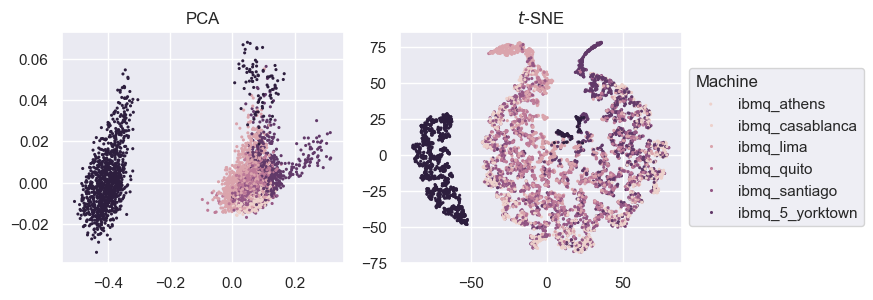

In [56]:
# Scatter plot the distributions in the reduced space (hue on machine).
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
size = 5
sns.scatterplot(x=xs_train_pca[:,0], y=xs_train_pca[:,1], hue=ys_train, ax=ax1, s=size, linewidth=0)
sns.scatterplot(x=xs_train_tsne[:,0], y=xs_train_tsne[:,1], hue=ys_train, ax=ax2, s=size, linewidth=0)

# Beautification.
ax1.set_title('PCA')
ax2.set_title('$t$-SNE')
ax1.get_legend().remove()
legend = ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=machines, title='Machine')
legend._legend_box.align = "left"

## Multi-class Classification

Given the measurement of a quantum state, what is the probability distribution over the set of devices (for the likelihood of membership), and subsequently which device is most likely to have produced the state?

The paper has two considerations for the input: (1) considering measurement outcomes at a single measurement step $k\in[1,\dots,9]$; and (2) concatenating all measurement outcomes in an ordered series $1,\dots,k$. Since the circuit is supposedly regenerated and then measured independently for each measurement step $k$, the only tangible difference between them is *time*. This is the point, actually -- the elements of the ordered series are independent of one another, yet ordered in time. 

### Ideas for Single-measurement

We'll define a model then train it to classify a given probability distribution as belonging to one of the machines. We'll train on each of the $k$ to obtain $k$ models that have learnt to discriminate distributions by machine membership at each time step. Then we can use each of these models to test on each time step too, giving that we will yield $k$ accuracy scores per model -- how well does each model discriminate at a given time step, considering the time step it was trained in. 

If we find that models are only really capable of classifying in or very near the time step they were trained in, then we are discovering that time-ordered series of noise are necessary to distinguish machines. This was the broad conclusion of the paper, but their method was not as direct as this (for whatever reason). On the other hand, having a model trained at the $k$-th step being able to classify quite well at the ($k+k')$-th for some $k'\gg0$ tells us that there is enough information in a slice of time to understand the inherent difference between the noise being produced by machines -- time-dependent or otherwise.

Another thing that might be interesting is to train a model with *all* data with no regard to time. This may be considered a brute-force version of the aforementioned test for time-dependence, but I think this might lead to a model capable of doing well at time steps it has never seen. For the sake of this last point, we might like to only train on the first few time steps (say 5) and evaluate on the final time step (i.e. 9) to allow for some distance between train and test sets.

Finally, we may also find interesting resutls training a model to discriminate *the time step* rather than the machine. That is, given a probability distribution from a single machine, can we classify the time step in which it was generated. We might then find use for this classify as a "selector" of sorts for choosing better architectural choice later on (e.g. if we have $k$ different classifiers for each time step as suggested above, then this model could be used to decide which to use given an unknown state).

### A loss function for classifying noise fingerprints

The go-to loss for this kind of problem would be (categorical) cross-entropy loss;
$$
\ell_\text{CCE}:=-\sum_{i=1}^Cy_i\log\hat{y}_i\ ,
$$
where $C$ is the number of classes, and $y_i$ and $\hat y_i$ are the true and predicted label for the $i$-th class respectively (i.e. 0 for non-membership, 1 for membership). For us, we have a one-hot encoded vector, hence this will simplify to $-\log\hat y_j$, where $j$ is the true class.

### Training and testing within a single time step

Here we train a model to classify a given probability distribution, taken from the $k$-th measurement step, as belonging to one of the given machines. To test performance, we evaluate classification accuracy on  probability distributions taken from the same measurement step only -- model's trained on the $k$-th measurement step are *only* tested on samples from this step.

#### Multi-layer Perceptron (MLP)

In [16]:
# Function to perform a single training step (i.e. one epoch).
def training_step(model, loader, optimiser, loss_fn, verbose=True):
    # Use train mode.
    model.train()
    
    # Track the running loss and accuracy.
    running_loss = 0
    running_acc = 0
    
    # Iterate over the loader (if verbose is true, give a progress bar).
    for xs, ys_true in (tqdm(loader, desc='Training', leave=False) if False else loader):
        # Zero gradients.
        optimiser.zero_grad()
        
        # Predict labels.
        ys_pred = model(xs)
        
        # Compute loss (adding to the running loss) and calculate gradients.
        loss = loss_fn(ys_pred, one_hot(ys_true.to(int), num_classes=ys_pred.shape[-1]).to(float))
        running_loss += loss.item()
        loss.backward()
        
        # Hardmax to get predicted class and compute accuracy.
        ys_pred_hardmax = torch.argmax(ys_pred, dim=1)
        running_acc += torch.sum(ys_pred_hardmax == ys_true).item()
        
        # Adjust weights.
        optimiser.step()
        
    # Return the average loss and accuracy over the epoch.
    return running_loss / len(loader), running_acc / len(loader.dataset)

# Function to evaluate with the given loader (i.e. validation/testing).
def evaluate(model, loader, loss_fn, verbose=True):
    # Use evaluation mode.
    model.eval()
    
    # Track the running loss and accuracy.
    running_loss = 0
    running_acc = 0
    
    # For evaluation, we do not track gradients.
    with torch.no_grad():
        # Iterate over the loader (if verbose is true, give a progress bar).
        for xs, ys_true in (tqdm(loader, desc='Evaluating', leave=False) if False else loader):
            # Predict labels.
            ys_pred = model(xs)
            
            # Compute loss (adding to the running loss).
            running_loss += loss_fn(ys_pred, one_hot(ys_true.to(int), num_classes=ys_pred.shape[-1]).to(float)).item()
            
            # Hardmax to get predicted class and compute accuracy.
            ys_pred_hardmax = torch.argmax(ys_pred, dim=1)
            running_acc += torch.sum(ys_pred_hardmax == ys_true).item()
            
    # Return the average loss and accuracy over the loader.
    return running_loss / len(loader), running_acc / len(loader.dataset)

# Function to perform a full training routine.
def train(model, train_loader, val_loader, n_epochs, lr=1e-3, weight_decay=.0, verbose=False, save_path=None):
    # Create the save directory.
    if save_path: makedirs(save_path, exist_ok=True)
    
    # Set up an optimiser and loss function.
    optimiser = Adam(params=model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = CrossEntropyLoss()
    
    # Track the best validation loss so that we may return to the best weights on termination.
    best_val_loss = np.inf
    best_state = model.state_dict()
    
    # Remember the training statistics, just in case someone feels like plotting it.
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    
    for epoch_idx in tqdm(np.arange(1, n_epochs + 1), desc='Top-level training'):
        # Train the model.
        train_loss, train_acc = training_step(model, train_loader, optimiser, loss_fn, verbose)
        val_loss, val_acc = evaluate(model, val_loader, loss_fn, verbose)
        
        # Store those stats.
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update the best validation loss and remember the model's state.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
            
            # Save the model (if a save path has been given).
            if save_path: torch.save(best_state, f'{save_path}/state_dict.pt')
        
        # Print the stats (if verbose).
        if verbose:
            print(f'Epoch {epoch_idx:03d}: train loss - {train_loss:.3f}, val loss - {val_loss:.3f}, train acc - {train_acc:.3f}, val acc - {val_acc:.3f}')
            
    # Restore the best model in validation.
    model.load_state_dict(best_state)
            
    # Return the stats.
    return train_losses, train_accs, val_losses, val_accs

In [106]:
# Generate and train a model.
hidden_size = 128
mlp_model = Sequential(
    Linear(xs.shape[-1], hidden_size), ReLU(),
    Linear(hidden_size, hidden_size), ReLU(),
    Linear(hidden_size, len(machines)),
    Softmax()
)
train_losses, train_accs, val_losses, val_accs = train(mlp_model, train_dataloader, val_dataloader, n_epochs=100, lr=1e-3, verbose=True)

Top-level training:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\bwpri\anaconda3\envs\quantum-noise-ml\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 001: train loss - 1.685, val loss - 1.626, train acc - 0.328, val acc - 0.392
Epoch 002: train loss - 1.604, val loss - 1.592, train acc - 0.422, val acc - 0.431
Epoch 003: train loss - 1.583, val loss - 1.578, train acc - 0.433, val acc - 0.451
Epoch 004: train loss - 1.572, val loss - 1.566, train acc - 0.446, val acc - 0.453
Epoch 005: train loss - 1.566, val loss - 1.563, train acc - 0.456, val acc - 0.448
Epoch 006: train loss - 1.560, val loss - 1.556, train acc - 0.459, val acc - 0.468
Epoch 007: train loss - 1.557, val loss - 1.556, train acc - 0.465, val acc - 0.470
Epoch 008: train loss - 1.553, val loss - 1.557, train acc - 0.465, val acc - 0.465
Epoch 009: train loss - 1.549, val loss - 1.546, train acc - 0.470, val acc - 0.477
Epoch 010: train loss - 1.544, val loss - 1.545, train acc - 0.476, val acc - 0.470
Epoch 011: train loss - 1.542, val loss - 1.538, train acc - 0.478, val acc - 0.481
Epoch 012: train loss - 1.539, val loss - 1.540, train acc - 0.484, val acc 

Text(0.5, 0, 'Epoch')

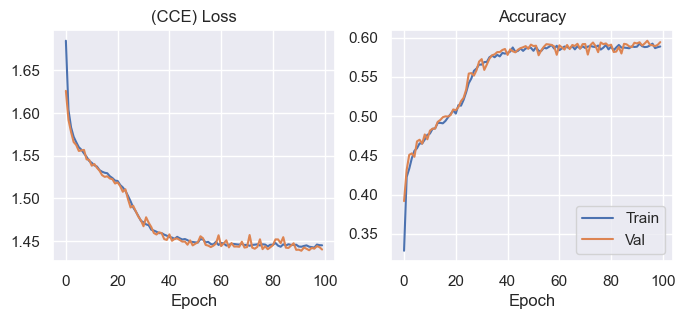

In [107]:
# Set up a figure and axes.
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(8, 3))

# Plot the stats.
epochs = np.arange(len(train_losses))
sns.lineplot(x=epochs, y=train_losses, ax=ax_loss)
sns.lineplot(x=epochs, y=val_losses, ax=ax_loss)
sns.lineplot(x=epochs, y=train_accs, ax=ax_acc, label='Train')
sns.lineplot(x=epochs, y=val_accs, ax=ax_acc, label='Val')

# Beautification.
ax_loss.set_title('(CCE) Loss')
ax_loss.set_xlabel('Epoch')

ax_acc.set_title('Accuracy')
ax_acc.set_xlabel('Epoch')

plt.show()

C:\Users\bwpri\anaconda3\envs\quantum-noise-ml\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'ibmq_athens'),
  Text(1, 0, 'ibmq_casablanca'),
  Text(2, 0, 'ibmq_lima'),
  Text(3, 0, 'ibmq_quito'),
  Text(4, 0, 'ibmq_santiago'),
  Text(5, 0, 'ibmq_5_yorktown')])

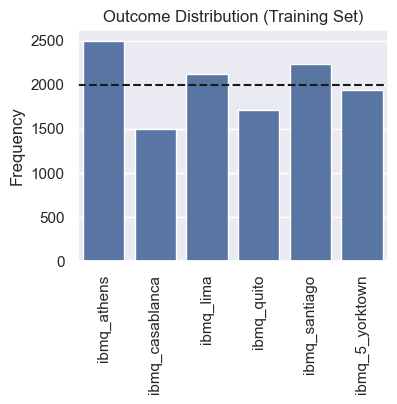

In [130]:
# Checking distribution of outputs (e.g. to see whether the model has any bias).
outcomes = torch.argmax(mlp_model(torch.tensor(xs[:,0,:])), dim=1)
outcome_frequencies = np.unique(outcomes, return_counts=True)

# Plotting.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.barplot(x=[machines[i] for i in outcome_frequencies[0]], y=outcome_frequencies[1], ax=ax)

# True frequency (for all machines is 2000).
ax.axhline(2000, color='k', linestyle='--')

# Beautifying.
ax.set_title('Outcome Distribution (Training Set)')
ax.set_ylabel('Frequency')
plt.xticks(rotation=90)

plt.show()

In [17]:
# Train a classifier for each measurement step.
models = {}
stats = {}
for step in range(9):
    # Define Datasets at this step.
    train_dataset = SingleMeasurementDistribution(xs_train, ys_train, step)
    val_dataset = SingleMeasurementDistribution(xs_val, ys_val, step)
    
    # Create Dataloader objects.
    batch_size = 64
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
    # Generate and train a model.
    hidden_size = 64
    mlp_model = Sequential(
        Linear(xs.shape[-1], hidden_size), ReLU(),
        Linear(hidden_size, hidden_size), ReLU(),
        Linear(hidden_size, len(machines)),
        Softmax()
    )
    train_losses, train_accs, val_losses, val_accs = train(mlp_model, train_dataloader, val_dataloader, n_epochs=50, lr=1e-3, verbose=False, save_path=f'./models/mlp/{datetime.now().strftime("%d-%m-%Y")}/{datetime.now().strftime("%H-%M-%S")}')
    
    # Store the model and stats.
    models[step] = mlp_model
    stats[step] = np.array([train_losses, train_accs, val_losses, val_accs])

Top-level training:   0%|          | 0/50 [00:00<?, ?it/s]

Top-level training:   0%|          | 0/50 [00:00<?, ?it/s]

Top-level training:   0%|          | 0/50 [00:00<?, ?it/s]

Top-level training:   0%|          | 0/50 [00:00<?, ?it/s]

Top-level training:   0%|          | 0/50 [00:00<?, ?it/s]

Top-level training:   0%|          | 0/50 [00:00<?, ?it/s]

Top-level training:   0%|          | 0/50 [00:00<?, ?it/s]

Top-level training:   0%|          | 0/50 [00:00<?, ?it/s]

Top-level training:   0%|          | 0/50 [00:00<?, ?it/s]

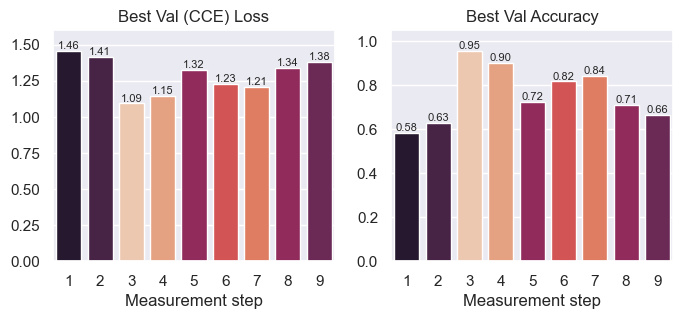

In [68]:
# Extract the best validation loss and accuracy from each model.
best_losses = [min(model_stats[2]) for model_stats in stats.values()]
best_accs = [max(model_stats[3]) for model_stats in stats.values()]

# Colour palette (https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot).
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

# Bar plot them.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
sns.barplot(x=np.arange(1, 10), y=best_losses, ax=ax1, palette=colors_from_values(best_losses, 'rocket_r'))
sns.barplot(x=np.arange(1, 10), y=best_accs, ax=ax2, palette=colors_from_values(best_accs, 'rocket'))

# Label the bars.
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', fontsize=8)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f', fontsize=8)

# Beautification.
ax1.set_title('Best Val (CCE) Loss')
ax2.set_title('Best Val Accuracy')
ax1.set_xlabel('Measurement step')
ax2.set_xlabel('Measurement step')
ax1.set_ylim(0, 1.6)
ax2.set_ylim(0, 1.05)

plt.savefig('./figures/mlp/single-measurement-training/performance-by-measurement-step.pdf', bbox_inches='tight')

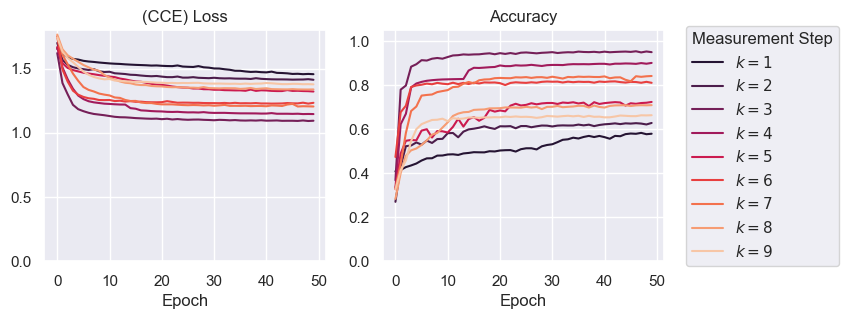

In [21]:
# Set up a figure and axes.
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(8, 3))

# Plot the stats for all models.
epochs = np.arange(len(train_losses))
palette = sns.color_palette('rocket', len(stats.keys()))
for i, model_stats in enumerate(stats.values()):
    sns.lineplot(x=epochs, y=model_stats[2], ax=ax_loss, color=palette[i])
    sns.lineplot(x=epochs, y=model_stats[3], ax=ax_acc, label=f'$k={i+1}$', color=palette[i])

# Beautification.
ax_loss.set_title('(CCE) Loss')
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylim(0, 1.8)

ax_acc.set_title('Accuracy')
ax_acc.set_xlabel('Epoch')
ax_acc.set_ylim(0, 1.05)

legend = ax_acc.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title='Measurement Step')
legend._legend_box.align = "left"

plt.savefig('./figures/mlp/single-measurement-training/training-curves-by-measurement-step.pdf', bbox_inches='tight')

In [32]:
# For each model, evaluate on each time step to understand its generality.
accs = {i : [] for i in models.keys()}
for i, model in tqdm(models.items(), desc=f'Evaluating models'):
    for step in range(9):
        # Populate a Dataloader with test samples.
        batch_size = 64
        test_dataset = SingleMeasurementDistribution(xs_test, ys_test, step)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        
        # Evaluate the model on these data.
        loss_fn = CrossEntropyLoss()
        accs[i].append(evaluate(model, test_dataloader, loss_fn, verbose=False)[1])

Evaluating models:   0%|          | 0/9 [00:00<?, ?it/s]

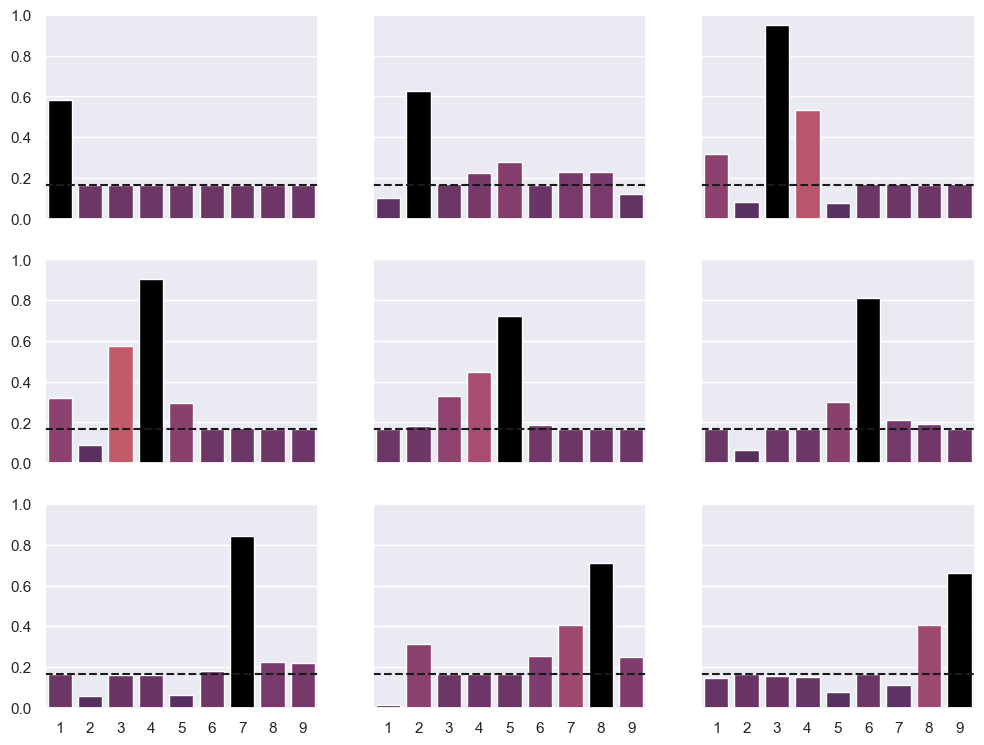

In [86]:
# Create a grid of bar charts showing the performance of each model on each measurement step.
fig, axes = plt.subplots(3, 3, figsize=(4*3, 3*3), sharey='row', sharex='col')

# Colour palette.
def colors_from_values(values, palette_name):
    indices = np.round(np.array(values) * 100).astype(np.int32)
    palette = sns.color_palette(palette_name, 100)
    return np.array(palette).take(indices, axis=0)

# Plot bars.
for i, ax in enumerate(axes.flatten()):
    # Set the i-th bar (the measurement step this model was trained on) to be black.
    palette = colors_from_values(accs[i], 'flare_r')
    palette[i] = [.0, .0, .0]
    
    sns.barplot(x=np.arange(1, 10), y=accs[i], ax=ax, palette=palette)
    
    # Add a dashed line on the performance achieved by random guessing.
    ax.axhline(1/len(machines), color='k', linestyle='--')
    
# Beautification.
axes[0][0].set_ylim(0, 1)
axes[1][0].set_ylim(0, 1)
axes[2][0].set_ylim(0, 1)

plt.savefig('./figures/mlp/single-measurement-training/performance-across-all-measurement-steps.pdf', bbox_inches='tight')

#### Support Vector Machine (SVM)

In [87]:
# Build an SVM for each measurement step.
models = {}
stats = {}
for step in tqdm(range(9), desc='Fitting SVMs'):
    # Define and fit a classifier on the training data.
    svm_model = SVC(kernel='rbf', decision_function_shape='ovr').fit(xs_train[:,step,:], ys_train)
    
    # Make predictions for the validation set.
    ys_train_pred = svm_model.predict(xs_train[:,step,:])
    ys_val_pred = svm_model.predict(xs_val[:,step,:])
    
    # Calculate accuracy.
    eps = 1e-3
    train_acc = sum(ys_train == ys_train_pred) / ys_train.shape[0]
    val_acc = sum(ys_val == ys_val_pred) / ys_val.shape[0]
    
    # Remember the model and stats.
    models[step] = svm_model
    stats[step] = [train_acc, val_acc]

Fitting SVMs:   0%|          | 0/9 [00:00<?, ?it/s]

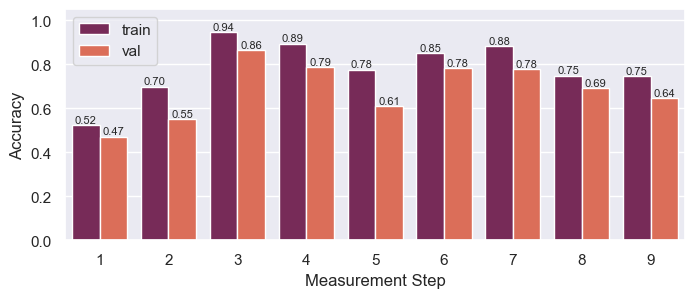

In [89]:
# Put the data into a DataFrame -- makes it easy to do grouped bar plots.
svm_data = pd.DataFrame({
    'Measurement Step' : np.array(list(stats.keys()) * 2) + 1,
    'Accuracy' : [x for x, _ in stats.values()] + [x for _, x in stats.values()],
    'Dataset' : ['train'] * len(stats) + ['val'] * len(stats)
})

# Bar plot them.
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
sns.barplot(data=svm_data, x='Measurement Step', y='Accuracy', hue='Dataset', palette='rocket', ax=ax)

# Label the bars.
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8)

# Beautification.
ax.set_ylim(0, 1.05)
ax.legend(loc='upper left')

plt.savefig('./figures/svm/single-measurement-training/performance-by-measurement-step.pdf', bbox_inches='tight')

In [91]:
# For each model, evaluate on each time step to understand its generality.
accs = {i : [] for i in models.keys()}
for i, model in tqdm(models.items(), desc=f'Evaluating models'):
    for step in range(9):       
        # Evaluate the model at this measurement step.
        ys_pred = model.predict(xs_test[:,step,:])
        accs[i].append(sum(ys_pred == ys_test) / len(ys_test))

Evaluating models:   0%|          | 0/9 [00:00<?, ?it/s]

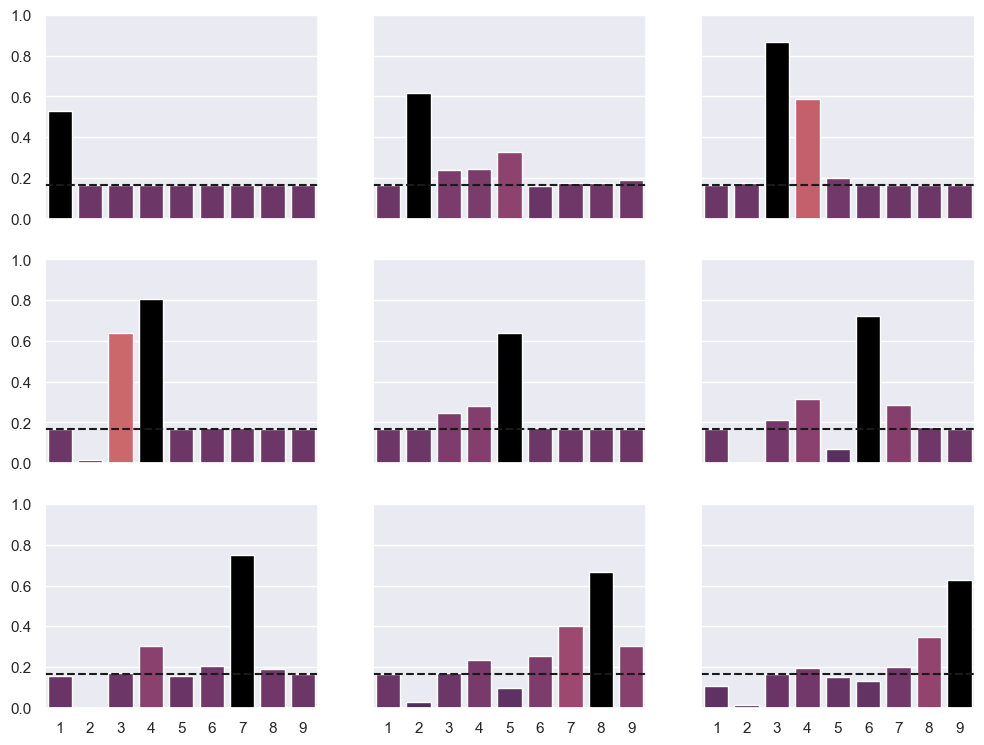

In [92]:
# Create a grid of bar charts showing the performance of each model on each measurement step.
fig, axes = plt.subplots(3, 3, figsize=(4*3, 3*3), sharey='row', sharex='col')

# Colour palette.
def colors_from_values(values, palette_name):
    indices = np.round(np.array(values) * 100).astype(np.int32)
    palette = sns.color_palette(palette_name, 100)
    return np.array(palette).take(indices, axis=0)

# Plot bars.
for i, ax in enumerate(axes.flatten()):
    # Set the i-th bar (the measurement step this model was trained on) to be black.
    palette = colors_from_values(accs[i], 'flare_r')
    palette[i] = [.0, .0, .0]
    
    sns.barplot(x=np.arange(1, 10), y=accs[i], ax=ax, palette=palette)
    
    # Add a dashed line on the performance achieved by random guessing.
    ax.axhline(1/len(machines), color='k', linestyle='--')
    
# Beautification.
axes[0][0].set_ylim(0, 1)
axes[1][0].set_ylim(0, 1)
axes[2][0].set_ylim(0, 1)

plt.savefig('./figures/svm/single-measurement-training/performance-across-all-measurement-steps.pdf', bbox_inches='tight')